# IMPORTING LIBRARIES

In [1]:
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from matplotlib.colors import ListedColormap
from PIL import Image, ImageDraw


# PLOTTING FUNCTIONS

In [2]:
def draw_transp_ellipse(img, xy, **kwargs):
    """ Draws an ellipse inside the given bounding box onto given image.
        Supports transparent colors
    """
    transp = Image.new('RGBA', img.size, (0,0,0,0))  # Temp drawing image.
    draw = ImageDraw.Draw(transp, "RGBA")
    draw.ellipse(xy, **kwargs)
    img.paste(Image.alpha_composite(img, transp))

def plotting_channel_contributions(brain_image, chs_all, chs_inc, ch_contributions, ch_set):
    """
    DESCRIPTION:
    Plotting channels which show a significant change in RMS.
    
    INPUT VARIABLES:
    brain_image:      [string]; Filename of the brain image.
    chs_all:          [list > strings (eeg channel names)]: List of all channels . 
    chs_inc:          [list > strings (eeg channel names)]; List of all channels that will be plotted.
    ch_contributions: [dict (key: channel ID; value: float)]; Channel contributions between 0-1.
    ch_set:           [string (AllChannels/NoChan112/Handknob)]; The set of channels that will be plotted.
    """
    
    # COMPUTATION:
    
    # Uploading brain image.
    brain_img = Image.open(brain_image + '.jpg').convert('RGBA')

    # Read in channel coordinates and radius on brain and channel mapping.
    with open("../SourceData/ch_coords_on_brain", "rb") as fp:  
         ch_coords = pickle.load(fp)

    # Read in list of channels. Each channel maps to a set of coordinates from ch_coords.
    with open("../SourceData/ch_map_to_coords", "rb") as fp:  
         ch_mapping = pickle.load(fp)
    
    # Creating the list of excluded channels.
    chs_exc = [ch for ch in chs_all if ch not in chs_inc]
    
    # Initializing an array of all channel contributions.
    n_chs_all             = len(chs_all)
    ch_contribution_array = np.zeros((n_chs_all,))
    
    # Iterating across all channels, but only extracting channel contributions from included channels..
    for n, ch in enumerate(chs_all):
        if ch in chs_inc:
            ch_contribution_array[n] = ch_contributions[ch]

    # Normalizing the channel contribution such that the maximum contribution is 0.99.
    ch_contribution_array_norm = (ch_contribution_array-0)/(np.max(ch_contribution_array)-0) * 0.99

    # Sorting channels in order of ascending contributions. This is so that channels with larger contributions overlap on top
    # of channels with smaller contributions, when drawing ellipses.
    chs_all_sorted = [x for _, x in sorted(zip(ch_contribution_array_norm, chs_all))]
    ch_contribution_array_norm.sort()
    
        
    # PLOTTING
    fig = plt.figure()
    
    # Iterating across all channels. 
    for n, ch in enumerate(chs_all_sorted):
        
        # Extracting the coordinates and radius for the current channel.
        ch_ind = ch_mapping.index(ch)
        x, y, r = ch_coords[ch_ind,:]
        
        # Creating the radius adn the transparency of the electrode based on the contribution
        r            = r * (1 + 2*ch_contribution_array_norm[n])
        transparency = int(135*ch_contribution_array_norm[n] + 120) 
        
        # Transforming the color of the current channel to a tuple.
        if ch in chs_inc:
            
            if ch_set== 'AllChannels':
                this_color = tuple(np.concatenate(([100, 149, 237], np.array([transparency])), axis=0)) # All Channels. Cornflower blue
            if ch_set== 'NoChan112':
                this_color = tuple(np.concatenate(([72, 209, 204], np.array([transparency])), axis=0)) # No Chan 112. Medium turquoise
            if ch_set== 'Handknob':
                this_color = tuple(np.concatenate(([240, 128, 128], np.array([transparency])), axis=0)) # Handknob 4x3 grid. Light Coral
            
        # Leaving excluded electrodes as white.
        if ch in chs_exc:
            this_color = 'white'
            this_color = tuple(np.concatenate(([255, 255, 255], np.array([128])), axis=0))
            
        # Creating a Draw object
        draw = ImageDraw.Draw(brain_img);

        # Creating the ellipse.
        upper_left_x  = int(x-r) 
        upper_left_y  = int(y-r) 
        lower_right_x = int(x+r) 
        lower_right_y = int(y+r) 
        draw_transp_ellipse(brain_img, (upper_left_x, upper_left_y, lower_right_x, lower_right_y),
                            fill=this_color, outline=(54, 69, 79, 255), width = 8)
        
    plt.imshow(brain_img)
    plt.axis('off')


# CREATING CHANNEL LISTS

In [3]:
# Creating a list of all channels.
chs_all = ['chan'+str(n) for n in range(1,129)]


# PLOTTING CONTRIBUTIONS OF ALL CHANNELS

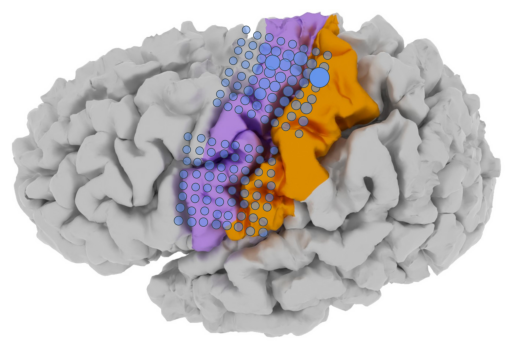

In [4]:
# Uploading the xlsx sheet as a dataframe and converting it to a dictionary.
channel_contributions = pd.read_excel('../SourceData/channel_contributions_all_channels.xlsx')
channel_contributions.set_index('Channel', inplace=True)
channel_contributions = channel_contributions.to_dict()['Relative Contribution']

# Extracting the keys of the channel_contributions dictionary as the list of included channels.
chs_include_all_channels = list(channel_contributions.keys())

# Plotting
plotting_channel_contributions('../SourceData/brain_mri', chs_all, chs_include_all_channels, channel_contributions, 'AllChannels')

# PLOTTING CONTRIBUTIONS OF ALL CHANNELS EXCEPT 112

In [ ]:
# Uploading the xlsx sheet as a dataframe and converting it to a dictionary.
channel_contributions = pd.read_excel('../SourceData/channel_contributions_no_chan112.xlsx')
channel_contributions.set_index('Channel', inplace=True)
channel_contributions = channel_contributions.to_dict()['Relative Contribution']

# Extracting the keys of the channel_contributions dictionary as the list of included channels.
chs_include_nochan112 = list(channel_contributions.keys())

# Plotting
plotting_channel_contributions('../SourceData/brain_mri', chs_all, chs_include_nochan112, channel_contributions, 'NoChan112')

# PLOTTING CONTRIBUTIONS OF ONLY HANDKNOB

In [ ]:
# Uploading the xlsx sheet as a dataframe and converting it to a dictionary.
channel_contributions = pd.read_excel('../SourceData/channel_contributions_handknob.xlsx')
channel_contributions.set_index('Channel', inplace=True)
channel_contributions = channel_contributions.to_dict()['Relative Contribution']

# Extracting the keys of the channel_contributions dictionary as the list of included channels.
chs_include_nochan112 = list(channel_contributions.keys())

# Plotting
plotting_channel_contributions('../SourceData/brain_mri', chs_all, chs_include_nochan112, channel_contributions, 'Handknob')